In [2]:
addprocs(15);

In [1]:
workers()

1-element Array{Int64,1}:
 1

Load required modules

In [3]:
@everywhere using QR, HD

In [4]:
@everywhere using HDF5, JLD  # loading data

In [35]:
@everywhere using PyPlot  # plotting
@everywhere using Distributions

In [38]:
@everywhere using Mosek

## Direct Estimation

In [29]:
@everywhere function generate_data(n, p, s, noiseType, corType)
    
    if corType == 1
      # equal correlation
      Sigma = 0.5 * ones(p,p) + 0.2 * eye(p)
    elseif corType == 2
      # toeplitz
      rho = 0.8
      Sigma = zeros(Float64, p,p)
      for a=1:p
        for b=a:p
          t = rho^abs(a-b)
          Sigma[a,b] = t
          Sigma[b,a] = t
        end
      end
    elseif corType == 3
      # toeplitz
      rho = 0.1
      Sigma = zeros(Float64, p,p)
      for a=1:p
        for b=a:p
          t = rho^abs(a-b)
          Sigma[a,b] = t
          Sigma[b,a] = t
        end
      end
    else
      error("Not implemented")
    end

    sqSigma = sqrtm(Sigma)

    beta = linspace(1., 0.5, s)
    X = randn(n, p) * sqSigma    
    if noiseType == 1
      errTerm = randn(n)
    elseif noiseType == 2
      tdist = TDist(1)
      errTerm = rand(tdist, n)
    else
      error("Not implemented")
    end

    Y = X[:,1:s] * beta + errTerm 
    
    (Y, X, beta)
end

In [60]:
@everywhere function debiased_estimate(
    rep, lambdaQRArr, lambdaLassoArr, tau, indJ,
    n, p, s, noiseType, corType
    )
    
    srand(rep)
    Y, X, true_beta = generate_data(n, p, s, noiseType, corType)
    
    solver = Mosek.MosekSolver(LOG=0,
                     OPTIMIZER=Mosek.MSK_OPTIMIZER_FREE_SIMPLEX,
                     PRESOLVE_USE=Mosek.MSK_PRESOLVE_MODE_OFF)
    qr_problem = QRProblem(solver, X, Y)

    qr_path = compute_qr_path!(qr_problem, lambdaQRArr, tau; max_hat_s=20)
    qr_refit_path = compute_qr_path_refit!(qr_problem, qr_path)
    
    XX = cov(X, corrected=false, mean=0.)
    Xy = zeros(Float64, p)    
    Xy[indJ] = 1.
    lasso_var_path = compute_lasso_path(XX, Xy, lambdaLassoArr; max_hat_s=10)
    
    lasso_refit_var_path = compute_lasso_path_refit(lasso_var_path, XX, Xy)
    
    qr_path, qr_refit_path, lasso_var_path, lasso_refit_var_path
end    

In [66]:
@everywhere function computeF(rep) 
    lambdaQRArr = logspace(log10(0.4), log10(0.05), 30)
    lambdaLassoArr = logspace(log10(0.8), log10(0.1), 30)
    tau = 0.5
    indJ = 10    
    
    n = 1000
    p = 50
    s = 10
    corType = 2
    noiseType = 1
    
    @time debiased_estimate(
        rep, lambdaQRArr, lambdaLassoArr, tau, indJ,
        n, p, s, noiseType, corType)
end

In [67]:
res = pmap(computeF, [1]);

	From worker 2:	Solving 1/30    nnz ==  0
	From worker 2:	Solving 11/30    nnz ==  10
	From worker 2:	Solving 21/30    nnz ==  10
	From worker 2:	elapsed time: 1.34182638 seconds (147443568 bytes allocated, 13.80% gc time)


In [69]:
res[1][4][[1,9,10,11]]

4-element Array{Float64,1}:
  0.0824361
 -2.25674  
  4.67504  
 -2.25251  

## Collect Results

In [70]:
@everywhere function compute_coverage_refit_known_f(
    lambdaQRArr, lambdaLassoArr, tauArr, rep, indTau, indJ;
    simPath = "/scratch/midway/mkolar/qr", 
    corType = 1,
    noiseType = 1
    )    
    
    tau = tauArr[indTau]
    err_d = Normal()
    spF = 1. / pdf(err_d, 0 )
    
    # load data
    data = JLD.load("$(simPath)/data/data_rep_$(rep)_cor_$(corType)_noise_$(noiseType).jld")
    X = data["X"]
    Y = data["Y"]
    s = data["s"]
    true_beta = data["beta"]
    
    if indJ > s
        true_coef = 0.
    else
        true_coef = true_beta[indJ]
    end
    
    n, p = size(X)
    
    hSigma = X'*X / n
    
    residuals = Array(Float64, n)
    gradient = Array(Float64, p)
    
    num_covered = zeros(length(lambdaQRArr), length(lambdaLassoArr))
    num_appear = zeros(length(lambdaQRArr), length(lambdaLassoArr))
    
    # load result rep --> result
    if isfile("$(simPath)/path_rep_$(rep)_cor_$(corType)_noise_$(noiseType).jld")
        result = JLD.load("$(simPath)/path_rep_$(rep)_cor_$(corType)_noise_$(noiseType).jld")
    else
        return (num_appear, num_covered)
    end
        
    cur_qr_path = result["qr_tau_path"][indTau]
    cur_lasso_path = result["lasso_var_path"][indJ]

    for indL1=1:length(cur_qr_path.lambdaArr)        
        estim_support_qr = find(cur_qr_path.beta[indL1])
        refit_qr = result["qr_refit_tau_path"][indTau][estim_support_qr]
        
        for indL2=1:length(cur_lasso_path.lambdaArr)
            estim_support_lasso = find(cur_lasso_path.beta[indL2])
            refit_lasso = result["lasso_refit_var_path"][indJ][estim_support_lasso]

            for i=1:n
                tmp = Y[i] - refit_qr.intercept - dot(vec(X[i, refit_qr.beta.rowval]), refit_qr.beta.nzval)
                if tmp < 0.
                    residuals[i] = tau - 1
                else
                    residuals[i] = tau
                end
            end
            At_mul_B!(gradient, X, residuals)              
            
            hb_debias = refit_qr.beta[indJ] + dot(refit_lasso, gradient[estim_support_lasso]) * spF / n
            eSigma = dot(refit_lasso, hSigma[estim_support_lasso, estim_support_lasso] * refit_lasso) * tau * (1 - tau) * spF^2 / n
            lb = hb_debias - 1.96 * sqrt( eSigma )
            ub = hb_debias + 1.96 * sqrt( eSigma )            
            
            num_appear[indL1, indL2] += 1
            if (lb < true_coef < ub)
                num_covered[indL1, indL2] += 1
            end
            
        end
    end
    
    (num_covered, num_appear)
end

## Computing coverage

In [90]:
@everywhere function loadF(rep) 
    lambdaQRArr = logspace(log10(0.4), log10(0.05), 30)
    lambdaLassoArr = logspace(log10(0.8), log10(0.1), 30)
    tauArr = [0.3:0.02:0.7]
    indTau = findfirst(tauArr,0.5)
    indJ = 1
    
    simPath = "/scratch/midway/mkolar/qr"    
    corType = 2
    noiseType = 1
    
    compute_coverage_refit_known_f(
        lambdaQRArr, lambdaLassoArr, tauArr, rep, indTau, indJ;
        simPath = simPath, 
        corType = corType,
        noiseType = noiseType)    
end

In [91]:
numRep = 350
colRes = pmap(loadF, [1:numRep]);

tmp[10:30,10:30] => [0.9514285714285714 0.9514285714285714 0.9514285714285714 0.9514285714285714 0.9514285714285714 0.9514285714285714 0.9514285714285714 0.9514285714285714 0.9514285714285714 0.9514285714285714 0.9514285714285714 0.9514285714285714 0.9514285714285714 0.9514285714285714 0.9457142857142857 0.9396551724137931 0.933993399339934 0.9457364341085271 1.0 NaN NaN
 0.9485714285714286 0.9485714285714286 0.9485714285714286 0.9485714285714286 0.9485714285714286 0.9485714285714286 0.9485714285714286 0.9485714285714286 0.9485714285714286 0.9485714285714286 0.9485714285714286 0.9485714285714286 0.9485714285714286 0.9485714285714286 0.94 0.9367816091954023 0.9273927392739274 0.9457364341085271 1.0 NaN NaN
 0.9542857142857143 0.9542857142857143 0.9542857142857143 0.9542857142857143 0.9542857142857143 0.9542857142857143 0.9542857142857143 0.9542857142857143 0.9542857142857143 0.9542857142857143 0.9542857142857143 0.9542857142857143 0.9542857142857143 0.9542857142857143 0.9428571428571428

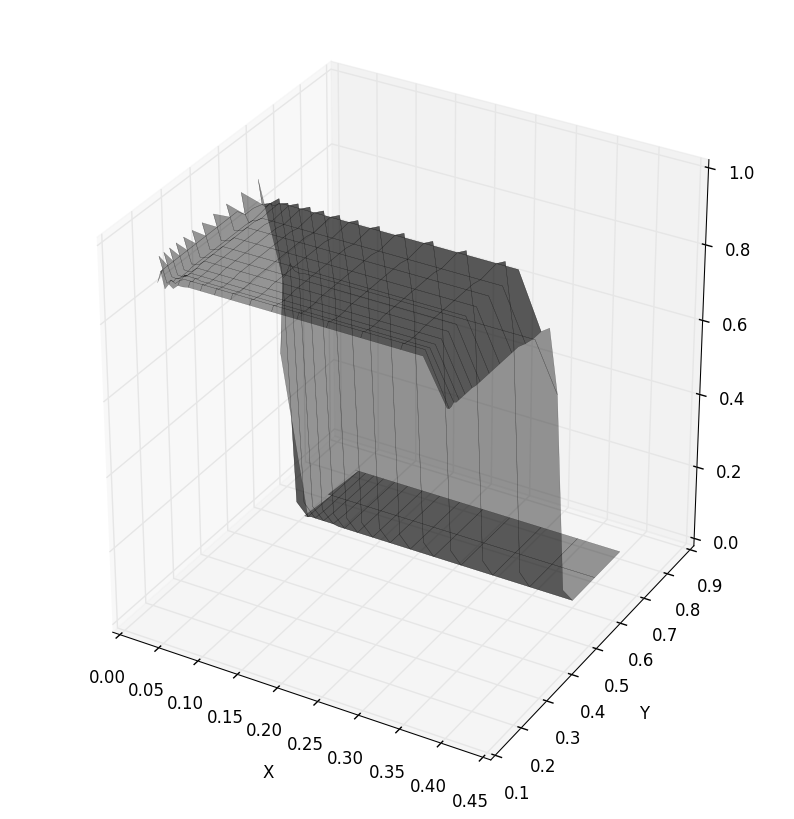

PyObject <matplotlib.text.Text object at 0x7f85a941ef90>

In [93]:
agr_num_covered = zeros(30, 30)
agr_num_appear = zeros(30, 30)

for j=1:numRep
    agr_num_covered += colRes[j][1]
    agr_num_appear += colRes[j][2]
end

tmp = agr_num_covered ./ agr_num_appear

xgrid = repmat(logspace(log10(0.4), log10(0.05), 30)', 30, 1)
ygrid = repmat(logspace(log10(0.8), log10(0.1), 30), 1, 30)

fig = figure("pyplot_surfaceplot",figsize=(10,10))
ax = fig[:add_subplot](1,1,1, projection = "3d") 
ax[:plot_surface](xgrid, ygrid, tmp, rstride=2,edgecolors="k", cstride=2, cmap=ColorMap("gray"), alpha=0.4, linewidth=0.25) 
xlabel("X") 
ylabel("Y")

LoadError: PyError (:PyObject_Call) <type 'exceptions.RuntimeError'>
RuntimeError(u'No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).',)
  File "/home/mkolar/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.py", line 2147, in colorbar
    raise RuntimeError('No mappable was found to use for colorbar '

while loading In[72], in expression starting on line 1

Kill Workers

In [ ]:
rmprocs(workers())

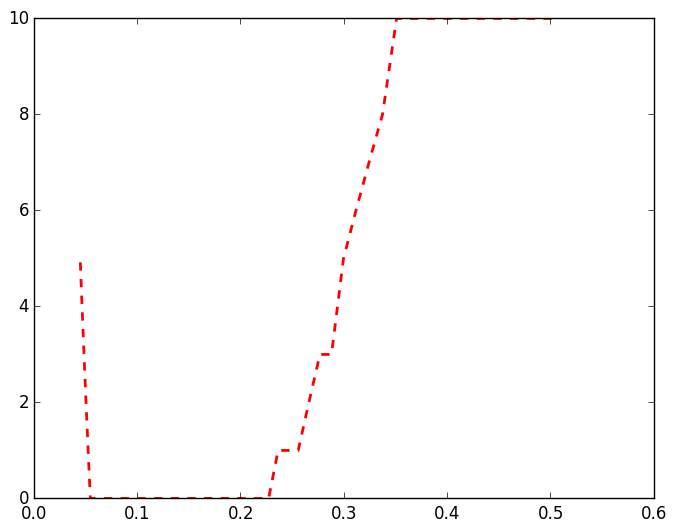

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fb396a4a450>

In [105]:
h_dist = zeros(100)
num_exp = zeros(100)
s = 10
numRep = 90
for rep=1:numRep
    cur_qr_path = simRes[1]["qr_tau_path"][indTau]
    for indLambda=1:length(cur_qr_path.lambdaArr)
        estim_support = find(cur_qr_path.beta[indLambda])
        h_dist[indLambda] += length(setdiff(1:s, estim_support)) + length(setdiff(estim_support, 1:s))
        num_exp[indLambda] += 1
    end    
end

plot(lambdaArr, h_dist ./ num_exp, color="red", linewidth=2.0, linestyle="--")

## For Debugging

In [9]:
simPath = "/scratch/midway/mkolar/qr1"
rep = 1
corType = 2
noiseType = 1

lambdaQRArr = linspace(0.4, 0.0, 100)
lambdaLassoArr = linspace(0.8, 0.05, 100)
tauArr = [0.3:0.02:0.7]
indTau = findfirst(tauArr,0.5)
indJ = 10


data = JLD.load("$(simPath)/data/data_rep_$(rep)_cor_$(corType)_noise_$(noiseType).jld")
X = data["X"]
Y = data["Y"]
s = data["s"]
true_beta = data["beta"]

tau = 0.5
err_d = Normal()
spF = 1. / pdf(err_d, 0 )

n, p = size(X)

result = JLD.load("$(simPath)/path_rep_$(rep)_cor_$(corType)_noise_$(noiseType).jld");

In [11]:
hSigma = X'*X / n

residuals = Array(Float64, n)
g = Array(Float64, p)

num_covered = zeros(length(lambdaQRArr), length(lambdaLassoArr))
num_appear = zeros(length(lambdaQRArr), length(lambdaLassoArr))

cur_qr_path = result["qr_tau_path"][indTau]
cur_lasso_path = result["lasso_var_path"][indJ];

In [22]:
@show lambdaQRArr[95]
cur_qr_path.beta[95]

lambdaQRArr[95] => 0.020202020202020204


100x1 sparse matrix with 16 Float64 entries:
	[1  ,   1]  =  0.919943
	[2  ,   1]  =  0.981416
	[3  ,   1]  =  0.739849
	[4  ,   1]  =  0.608789
	[5  ,   1]  =  0.505494
	[22 ,   1]  =  -0.0235629
	[24 ,   1]  =  -0.00940574
	[35 ,   1]  =  -0.0119907
	[49 ,   1]  =  0.00966997
	[57 ,   1]  =  -0.00361409
	[58 ,   1]  =  -0.0144407
	[72 ,   1]  =  0.0126296
	[76 ,   1]  =  0.00595938
	[79 ,   1]  =  0.0269848
	[83 ,   1]  =  -0.0172218
	[90 ,   1]  =  -0.00814166

In [42]:
estim_support_lasso = find(cur_lasso_path.beta[indL2])
refit_lasso = result["lasso_refit_var_path"][indJ][estim_support_lasso]

2-element Array{Float64,1}:
  2.78076
 -2.16707

In [43]:
for i=1:n
    tmp = Y[i] - refit_qr.intercept - dot(vec(X[i, refit_qr.beta.rowval]), refit_qr.beta.nzval)
    if tmp < 0.
        residuals[i] = tau - 1
    else
        residuals[i] = tau
    end
end
At_mul_B!(g, X, residuals)    

hb_debias = refit_qr.beta[indJ] + dot(refit_lasso, g[estim_support_lasso]) * spF / n

0.9828877467764753

In [53]:
refit_lasso' * g[estim_support_lasso] * spF / n

1-element Array{Float64,1}:
 -0.00286327

In [54]:
eSigma = dot(refit_lasso, hSigma[estim_support_lasso, estim_support_lasso] * refit_lasso) * tau * (1 - tau) * spF^2 / n

0.004368003917468316

In [56]:
lb = hb_debias - 1.96 * sqrt( eSigma )
ub = hb_debias + 1.96 * sqrt( eSigma )
lb, ub

(0.8533496294158069,1.1124258641371436)

In [39]:


for indL1=1:length(cur_qr_path.lambdaArr)
    estim_support_qr = find(cur_qr_path.beta[indL1])
    refit_qr = result["qr_refit_tau_path"][indTau][estim_support_qr]

    for indL2=1:length(cur_lasso_path.lambdaArr)
        estim_support_lasso = find(cur_lasso_path.beta[indL2])
        refit_lasso = result["lasso_refit_var_path"][indJ][estim_support_lasso]

        for i=1:n
            tmp = Y[i] - refit_qr.intercept - dot(vec(X[i, refit_qr.beta.rowval]), refit_qr.beta.nzval)
            if tmp < 0.
                residuals[i] = tau - 1
            else
                residuals[i] = tau
            end
        end
        At_mul_B!(g, X, residuals)              

        hb_debias = refit_qr.beta[indJ] + dot(refit_lasso, g[estim_support_lasso]) * spF / n
        eSigma = dot(refit_lasso, hSigma[estim_support_lasso, estim_support_lasso] * refit_lasso) * tau * (1 - tau) * spF^2    
        lb = hb_debias - 1.96 * sqrt( eSigma )
        ub = hb_debias + 1.96 * sqrt( eSigma )

        num_appear[indL1, indL2] += 1
        if (lb < true_beta[indJ] < ub)
            num_covered[indL1, indL2] += 1
        end

    end
end

## Testing Parallel

In [27]:
@everywhere function generate_rnd(rep)
    srand(rep)
    randn()
end

In [28]:
res = pmap(generate_rnd, [1:10])

10-element Array{Any,1}:
  0.297288  
  0.739621  
  1.19156   
 -1.76112   
  1.46431   
 -1.314     
  1.39509   
 -0.00762343
 -1.03324   
 -0.15548   